In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import scipy.io as sio
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix, precision_recall_fscore_support
import timm
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn 
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
sep = '\\' if os.name == 'nt' else '/'

In [5]:
hiperparametros = {
    'epocas' : 150,
    'lr' : 0.001,
    'batch_size' : 64,
    'seed' : 56389856,
    'dropout' : 0.1
}


In [6]:
path_thorres = 'D:/MSc/img_bispectrum/test/bisp_thorres/'
path_abdo = 'D:/MSc/img_bispectrum/test/bisp_abdo/'
path_labels = 'D:/MSc/img_bispectrum/test/labels_img/'


In [7]:
files_thorres = glob.glob(path_thorres + '*')
files_abdo = glob.glob(path_abdo + '*')
files_labels = glob.glob(path_labels + '*')

In [8]:
len(files_thorres), len(files_abdo), len(files_labels)

(135366, 135366, 5000)

In [9]:
def search_and_order_files_of_subject(subject_name, files):
    
    lst = [path for path in files if subject_name in path]
    lista = [(path, eval(path.split('_')[-1].split('.')[0])) for path in lst]
    ordered_list = sorted(lista,  key=lambda x: x[1])
    
    return [element[0] for element in ordered_list]

In [11]:
def open_subject_labels(path):
    
    data = sio.loadmat(path)
    n_segments = data.get('n_segments')
    y_central_data = data.get('vec_all_central')
    y_hypopnea_data = data.get('vec_all_hypo')
    y_osa_data = data.get('vec_all_osa')
    y_events_data = data.get('vec_all_events')
    n_segments = data.get('n_segments')
    
    return y_central_data.squeeze(), y_hypopnea_data.squeeze(), y_osa_data.squeeze(), y_events_data.squeeze(), n_segments

In [12]:
class MyDatasetTest(Dataset):
    def __init__(self, label, subject_images_thorres, subject_images_abdo, y_events, y_central, y_osa, y_hypo) -> None:
        self.label = label
        self.subject_images_thorres = subject_images_thorres
        self.subject_images_abdo = subject_images_abdo
        self.y_events = y_events
        self.y_central = y_central
        self.y_osa = y_osa
        self.y_hypo = y_hypo
        
    def __getitem__(self, index):
        name_ind = self.label
        x_torres_ind = self.subject_images_thorres[index]
        x_abdo_ind = self.subject_images_abdo[index]
        y_events_ind = self.y_events[index]
        y_central_ind = self.y_central[index]
        y_hypo_ind = self.y_hypo[index]
        y_osa_ind = self.y_osa[index]

        thorres = torch.from_numpy(np.moveaxis(x_torres_ind / 255, -1, 0))
        abdores = torch.from_numpy(np.moveaxis(x_abdo_ind / 255, -1, 0))
        
        x = torch.cat([thorres, abdores], axis = 0)
        
        y = torch.Tensor([y_central_ind]).float()

        return x, y, name_ind

    def __len__(self):
        return len(self.subject_images_thorres)

In [13]:
model = timm.create_model('timm/resnetrs50.tf_in1k', pretrained=True, num_classes = 1, in_chans = 6).to(device)
model.load_state_dict(torch.load('C:/Users/marta/Desktop/TFM/test/regresion_CENTRAL_resnet18_propio_reg_lin_ResNetRS.pth'))

<All keys matched successfully>

In [14]:
criterion = torch.nn.HuberLoss(reduction= "mean")

In [15]:
def get_AHI_pred_real(outputs, labels):
    AHI_pred = sum(outputs)/len(outputs)*3
    AHI_real = sum(labels)/len(labels)*3
    
    return AHI_pred, AHI_real

In [42]:
df = pd.DataFrame(columns = ['Name', 'AHI_pred', 'AHI_real', 'loss_test'])

In [43]:
for label in tqdm(files_labels):
    subject_name = label.split(sep)[-1].split('_')[1]
    subject_files_thorres = search_and_order_files_of_subject(subject_name, files_thorres)
    subject_files_abdo = search_and_order_files_of_subject(subject_name, files_abdo)
    subject_images_thorres = [np.array(Image.open(path)) for path in subject_files_thorres]
    subject_images_abdo = [np.array(Image.open(path)) for path in subject_files_abdo]
    y_central_data, y_hypopnea_data, y_osa_data, y_events_data, n_segments = open_subject_labels(label)

    dataset = MyDatasetTest(label, subject_images_thorres, subject_images_abdo,
                            y_events_data, y_central_data, y_osa_data, y_hypopnea_data)

    dataloader = DataLoader(dataset, batch_size= hiperparametros['batch_size'], shuffle= True)

    model.eval()    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels, names = data[0].to(device, dtype=torch.float32), data[1].to(device), data[2]
            outputs = model(inputs)
            loss_val = criterion(outputs, labels)
            loss_medio_test = loss_val.item()
            AHI_pred_test, AHI_real_test = get_AHI_pred_real(outputs, labels)


    new_row = pd.DataFrame([[label.split('\\')[-1].split('_')[1], AHI_pred_test.item(), 
                             AHI_real_test.item(), loss_medio_test]], 
                           columns = ['Name', 'AHI_pred', 'AHI_real', 'loss_test'])
    
    
    df = pd.concat([df, new_row])
    
    

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [3:07:41<00:00,  2.25s/it]


In [44]:
df

,Name,AHI_pred,AHI_real,loss_test
0,shhs1-200078,0.1381,0.391304,0.05782
0,shhs1-200079,0.133989,0.130435,0.019737
0,shhs1-200081,0.191422,0.115385,0.020258
0,shhs1-200086,0.133317,0.0,0.001686
0,shhs1-200088,0.288544,0.272727,0.065161
...,...,...,...,...
0,shhs2-205785,0.187984,0.206897,0.026689
0,shhs2-205786,1.301675,4.354838,0.93806
0,shhs2-205796,0.401657,0.107143,0.048526
0,shhs2-205798,0.181758,0.636364,0.162547


## Ajuste de la regresión lineal

In [45]:
import json

In [46]:
with open('C:/Users/marta/Desktop/TFM/test/coefs_regresion_CENTRAL_resnet18_propio_reg_lin_ResNetRS.txt') as f:
    data = f.read()

In [47]:
coefs = json.loads(data)

In [48]:
AHI_pred_reg = coefs['intercept']+coefs['coef']*df.AHI_pred

In [92]:
AHI_pred_reg

0    0.281713
0    0.276293
0    0.352015
0    0.275407
0    0.480064
       ...   
0    0.347483
0    1.815816
0    0.629197
0    0.339273
0     0.72015
Name: AHI_pred, Length: 5000, dtype: object

In [93]:
df_reg = df

In [94]:
df_reg.loc[:, 'AHI_pred_reg'] = AHI_pred_reg

In [95]:
df_reg.head(3)

,Name,AHI_pred,AHI_real,loss_test,AHI_pred_reg
0,shhs1-200078,0.1381,0.391304,0.05782,0.281713
0,shhs1-200079,0.133989,0.130435,0.019737,0.276293
0,shhs1-200081,0.191422,0.115385,0.020258,0.352015


In [96]:
df_reg.to_csv('C:/Users/marta/Desktop/TFM/test/df_central_resnetrs_WITH_REGRESSION.csv')  

In [51]:
AHI_pred_disc = np.digitize(AHI_pred_reg, bins = np.array([5,15,30]))
AHI_real_disc = np.digitize(df.AHI_real, bins = np.array([5,15,30]))

In [52]:
kappa = cohen_kappa_score(AHI_pred_disc, AHI_real_disc)
accuracy = sum(AHI_pred_disc == AHI_real_disc).item()/len(AHI_real_disc)  
print('Kappa: ', kappa)
print('Accuracy: ', accuracy)

Kappa:  0.29662716593662164
Accuracy:  0.9782


In [53]:
def sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc_, AHI_pred_disc_, clase):
    FP = sum(AHI_pred_disc_[AHI_real_disc_ > clase] <= clase)
    TP = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] <= clase)
    TN = sum(AHI_pred_disc_[AHI_real_disc_ > clase] > clase)
    FN = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] > clase)
    sensibilidad = TP/(TP + FN)
    especifidad = TN/(TN + FP)
    VPP = TP/(TP + FP)
    VPN = TN/(TN + FN)
    
    AHI_real_disc_clase = np.copy(AHI_real_disc_)
    AHI_real_disc_clase[AHI_real_disc_clase > clase] = 100
    AHI_real_disc_clase[AHI_real_disc_clase <= clase] = 0

    AHI_pred_disc_clase = np.copy(AHI_pred_disc_)
    AHI_pred_disc_clase[AHI_pred_disc_clase > clase] = 100
    AHI_pred_disc_clase[AHI_pred_disc_clase <= clase] = 0
    
    best_cfmatrix_val_clase = confusion_matrix(AHI_real_disc_clase, AHI_pred_disc_clase)
    
    group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val_clase.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         best_cfmatrix_val_clase.flatten()/np.sum(best_cfmatrix_val_clase)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(best_cfmatrix_val_clase, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()

    return sensibilidad, especifidad, VPP, VPN

In [54]:
def sens_especif_mat_conf_por_clases(AHI_real_disc_, AHI_pred_disc_, clase):
    FP = sum(AHI_pred_disc_[AHI_real_disc_ == clase] == clase)
    TP = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] == clase)
    TN = sum(AHI_pred_disc_[AHI_real_disc_ == clase] != clase)
    FN = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] != clase)
    sensibilidad = TP/(TP + FN)
    especifidad = TN/(TN + FP)
    VPP = TP/(TP + FP)
    VPN = TN/(TN + FN)
    
    AHI_real_disc_clase = np.copy(AHI_real_disc_)
    AHI_real_disc_clase[AHI_real_disc_clase != clase] = 100

    AHI_pred_disc_clase = np.copy(AHI_pred_disc_)
    AHI_pred_disc_clase[AHI_pred_disc_clase != clase] = 100
    
    best_cfmatrix_val_clase = confusion_matrix(AHI_real_disc_clase, AHI_pred_disc_clase)
    
    group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val_clase.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         best_cfmatrix_val_clase.flatten()/np.sum(best_cfmatrix_val_clase)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(best_cfmatrix_val_clase, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()

    return sensibilidad, especifidad, VPP, VPN

# Cálculo de la sensibilidad, especifidad, VPP y VPN por clases

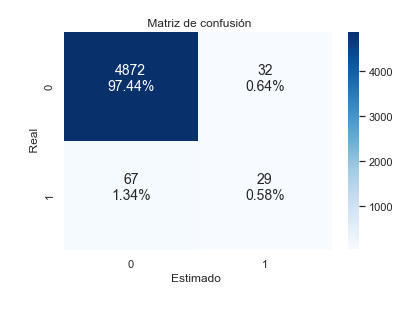

Sensibilidad =  0.9934747145187602
Especifidad =  0.0065252854812398045
VPP =  0.5
VPN =  0.5


In [56]:
try:
    sensibilidad_0, especifidad_0, VPP_0, VPN_0 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 0)
    print("Sensibilidad = ", sensibilidad_0)
    print("Especifidad = ", especifidad_0)
    print("VPP = ", VPP_0)
    print("VPN = ", VPN_0)
except ZeroDivisionError:
    pass


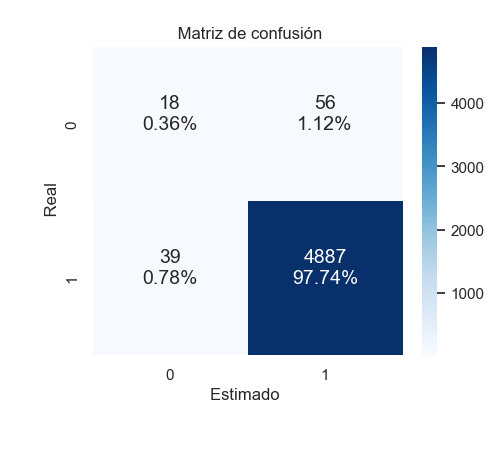

Sensibilidad =  0.00944154278826838
Especifidad =  0.7567567567567568
VPP =  0.7230769230769231
VPN =  0.011229195909364347


In [57]:
try:
    sensibilidad_1, especifidad_1, VPP_1, VPN_1 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 1)
    print("Sensibilidad = ", sensibilidad_1)
    print("Especifidad = ", especifidad_1)
    print("VPP = ", VPP_1)
    print("VPN = ", VPN_1)
except ZeroDivisionError:
    pass

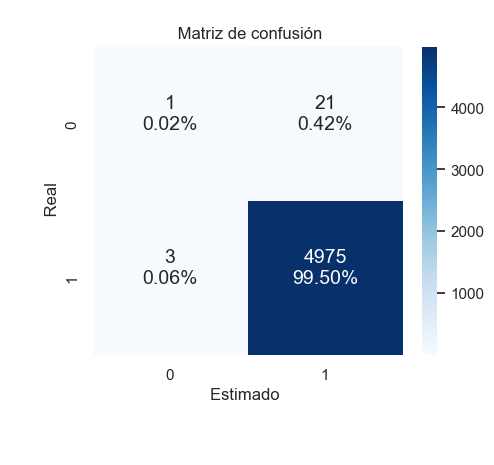

Sensibilidad =  0.0008
Especifidad =  0.9545454545454546
VPP =  0.8
VPN =  0.004185768387482559


In [58]:
try:
    sensibilidad_2, especifidad_2, VPP_2, VPN_2 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 2)
    print("Sensibilidad = ", sensibilidad_2)
    print("Especifidad = ", especifidad_2)
    print("VPP = ", VPP_2)
    print("VPN = ", VPN_2)
except ZeroDivisionError:
    pass

In [59]:
try:
    sensibilidad_3, especifidad_3, VPP_3, VPN_3 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 3)
    print("Sensibilidad = ", sensibilidad_3)
    print("Especifidad = ", especifidad_3)
    print("VPP = ", VPP_3)
    print("VPN = ", VPN_3)
except ZeroDivisionError:
    pass

# Cálculo de la sensibilidad y especifidad por cada clase o las clases inferiores a ella

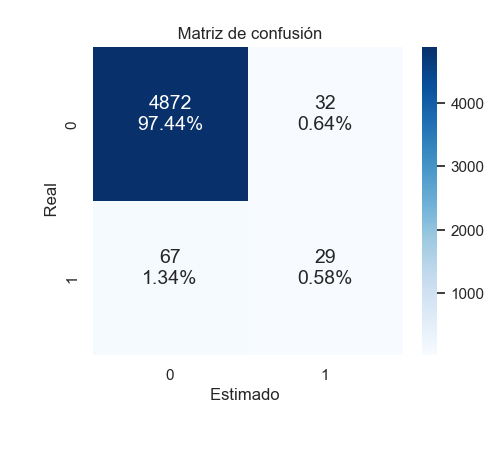

Sensibilidad =  0.9934747145187602
Especifidad =  0.3020833333333333
VPP =  0.9864345009111156
VPN =  0.47540983606557374


In [60]:
try:
    sensibilidad_0_inf, especifidad_0_inf, VPP_0_inf, VPN_0_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 0)
    print("Sensibilidad = ", sensibilidad_0_inf)
    print("Especifidad = ", especifidad_0_inf)
    print("VPP = ", VPP_0_inf)
    print("VPN = ", VPN_0_inf)
except ZeroDivisionError:
    pass

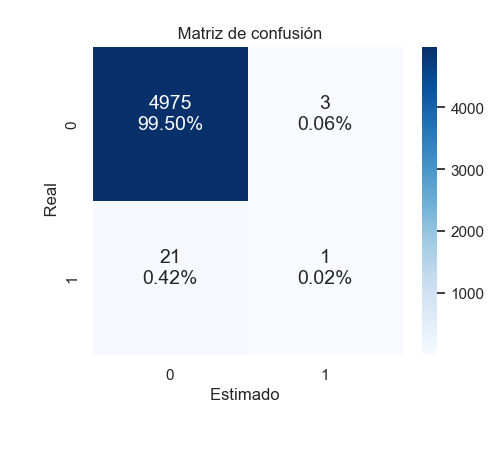

Sensibilidad =  0.9993973483326637
Especifidad =  0.045454545454545456
VPP =  0.9957966373098479
VPN =  0.25


In [61]:
try:
    sensibilidad_1_inf, especifidad_1_inf, VPP_1_inf, VPN_1_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 1)
    print("Sensibilidad = ", sensibilidad_1_inf)
    print("Especifidad = ", especifidad_1_inf)
    print("VPP = ", VPP_1_inf)
    print("VPN = ", VPN_1_inf)
except ZeroDivisionError:
    pass

In [62]:
try:
    sensibilidad_1_inf, especifidad_1_inf, VPP_1_inf, VPN_1_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 2)
    print("Sensibilidad = ", sensibilidad_1_inf)
    print("Especifidad = ", especifidad_1_inf)
    print("VPP = ", VPP_1_inf)
    print("VPN = ", VPN_1_inf)
except ZeroDivisionError:
    pass

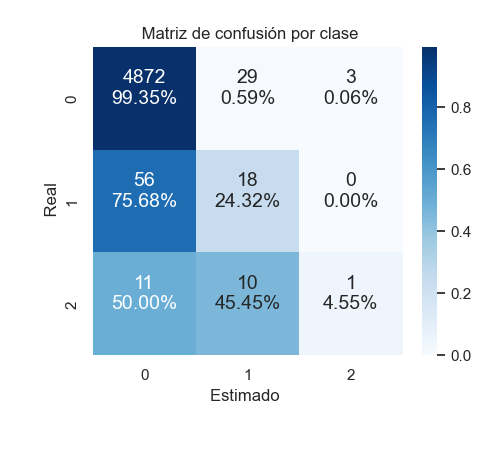

In [63]:
try:
    best_cfmatrix_val = confusion_matrix(AHI_real_disc, AHI_pred_disc)
    cf_mat_row = np.zeros((4,4))
    for i in range(best_cfmatrix_val.shape[0]):
        cf_mat_row[i,:] = best_cfmatrix_val[i]/sum(best_cfmatrix_val[i])
    
    group_counts = ["{0:0.0f}".format(value) for value in
            best_cfmatrix_val.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_mat_row.flatten()]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(4,4)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(cf_mat_row, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión por clase")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()
except ValueError:
    best_cfmatrix_val = confusion_matrix(AHI_real_disc, AHI_pred_disc)
    cf_mat_row = np.zeros((3,3))
    for i in range(best_cfmatrix_val.shape[0]):
        cf_mat_row[i,:] = best_cfmatrix_val[i]/sum(best_cfmatrix_val[i])
    
    group_counts = ["{0:0.0f}".format(value) for value in
            best_cfmatrix_val.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_mat_row.flatten()]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(3,3)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(cf_mat_row, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión por clase")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()